In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout,BatchNormalization
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from tensorflow.keras import activations

In [2]:
import os
import cv2
import numpy as np

# Constants
image_size = 224
labels = ['NORMAL', 'PNEUMONIA']
label_map = {'NORMAL': 0, 'PNEUMONIA': 1}  # Numeric encoding for labels

# Function to load and preprocess images
def load_images_from_folder(base_folder, labels, image_size, label_map):
    X, Y = [], []
    for label in labels:
        folder_path = os.path.join(base_folder, label)
        for file_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file_name)
            img = cv2.imread(img_path)
            if img is not None:  # Check if image is loaded
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                Y.append(label_map[label])  # Append numeric label
    return np.array(X), np.array(Y)

# Load datasets
train_folder = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_folder = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_folder = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

X_train, Y_train = load_images_from_folder(train_folder, labels, image_size, label_map)
X_test, Y_test = load_images_from_folder(test_folder, labels, image_size, label_map)
X_val, Y_val = load_images_from_folder(val_folder, labels, image_size, label_map)

In [3]:
# Print the shape of the first image from each dataset
print("Shape of the first image in X_train:", X_train[0].shape)
print("Shape of the first image in X_test:", X_test[0].shape)
print("Shape of the first image in X_val:", X_val[0].shape)


Shape of the first image in X_train: (224, 224, 3)
Shape of the first image in X_test: (224, 224, 3)
Shape of the first image in X_val: (224, 224, 3)


In [4]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(5216, 224, 224, 3)

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.1,random_state=101)

In [6]:
y_train_new = []
for i in y_train:
    y_train_new.append(i)  # Append the label as it is, no need to index into labels
y_train = np.array(y_train_new)  # Convert the list to a numpy array
y_train = tf.keras.utils.to_categorical(y_train)  # Convert to one-hot encoded

y_test_new = []
for i in y_test:
    y_test_new.append(i)  # Append the label as it is
y_test = np.array(y_test_new)  # Convert the list to a numpy array
y_test = tf.keras.utils.to_categorical(y_test)  # Convert to one-hot encoded

In [7]:
model = Sequential()


model.add(Conv2D(16, (3, 3), activation='relu',  padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.20))

model.add(Dense(2, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 945,698 (3.61 MB)

 Trainable params: 945,698 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
history = model.fit(X_train,y_train,epochs=20,validation_split=0.1)

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 134s 992ms/step - accuracy: 0.7991 - loss: 0.9839 - val_accuracy: 0.9021 - val_loss: 0.2117
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9470 - loss: 0.1398 - val_accuracy: 0.9468 - val_loss: 0.1358
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9610 - loss: 0.1174 - val_accuracy: 0.9766 - val_loss: 0.0664
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 130s 984ms/step - accuracy: 0.9775 - loss: 0.0654 - val_accuracy: 0.9723 - val_loss: 0.0899
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 130s 984ms/step - accuracy: 0.9818 - loss: 0.0507 - val_accuracy: 0.9596 - val_loss: 0.1105
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 131s 989ms/step - accuracy: 0.9817 - loss: 0.0476 - val_accuracy: 0.9638 - val_loss: 0.1081
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 130s 984ms/step - accuracy: 0.9851 - loss: 0.0411 - val_accuracy: 0.9596 - val_loss: 0.1378
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 129s 981ms/step - accuracy: 0.9897 - loss:


KeyboardInterrupt



In [10]:
history = model.evaluate(X_test,y_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - accuracy: 0.9515 - loss: 0.2484


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step


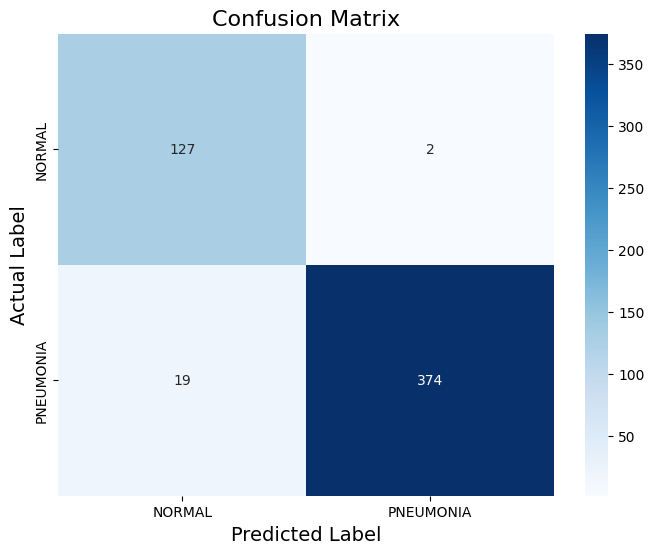

In [12]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict the classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Define class names
class_names = labels  # ['NORMAL', 'PNEUMONIA']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.show()
